# implement log segmentation
> page 22, john lind http://www.andrew.cmu.edu/user/suter/JLind_Thesis_2013_web.pdf
    

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import glob
def median_background(initial,startIdx,outInitial, NRot=720, NDet=2,NLayer=1,layerIdx=[0],end='.tif', imgshape=[2048,2048]):
    '''
    take median over omega as background
    initial: finle name initial. e.g.:'/home/heliu/work/shahani_feb19_part/nf_part/dummy_2_rt_before_heat_nf/dummy_2_rt_before_heat_nf_'
    startIdx: idex of first imagej.
    outInitial: output initial
    NRot: number of omega interval.
    NDet: number of detector.
    NLayer: number of layer.
    layerIdx: the index used for layers
    end: file end format.
    imgshape: image resolution
    '''
    lBkg = []
    imgStack = np.empty([imgshape[0], imgshape[1], NRot],dtype=np.int32)
    start = time.time()
    for layer in range(NLayer):
        for det in range(NDet):
            for rot in range(NRot):
                idx = layer * NDet * NRot + det * NRot + rot + startIdx
                fName = f'{initial}{idx:06d}{end}'
                imgStack[:,:,rot] = plt.imread(fName)
                sys.stdout.write(f'\r {rot}')
                sys.stdout.flush()
            bkg = np.median(imgStack, axis=2)
            np.save(f'{outInitial}_z{layer}_det_{det}.npy', bkg)
            lBkg.append(bkg)
    end = time.time()
    print('\r')
    print(end - start)
    return lBkg

def segmentation(img, bkg, baseline=10, minNPixel=4):
    '''
    
    '''
    imgSub = img- bkg
    imgSubMed = ndi.median_filter(imgSub,size=2)
    imgBase = imgSubMed - baseline
    imgBase[imgBase<0] = 0
    imgBaseMedian = ndi.median_filter(imgBase, size=2)
    log = ndi.gaussian_laplace(imgBaseMedian,sigma=1.5)
    label,N = ndi.label(log<0)
    label = ndi.grey_dilation(label,size=(3,3))
    lX = []
    lY = []
    lID = []
    lIntensity = []
    start = time.time()
# fill hole??? probably not a good idea in some cases.
    for i in range(N):
        mask = (label==i)
        # fill hole??? probably not a good idea in some cases.
        #mask = ndi.binary_fill_holes(mask)
        #mask = ndi.binary_dilation(mask,iterations=2)
        vMax = np.max(imgSubMed[mask].ravel())
        if vMax > baseline:
            x, y = np.where(mask*(imgSub>max(vMax*0.1,1)))
            if x.size>minNPixel:
                for i,xx in enumerate(x):
                    lX.append(xx)
                    yy = y[i]
                    lY.append(yy)
                    lIntensity.append(imgSub[xx,yy])
                    lID.append(label[xx,yy])
    end = time.time()
    print(f'time taken:{end- start}')
    return (img.shape[1] - np.array(lY)).astype(np.int32), np.array(lX).astype(np.int32), np.array(lID).astype(np.int32), np.array(lIntensity).astype(np.int32)

def reduce_image(initial,startIdx,bkgInitial,binInitial, NRot=720, NDet=2,NLayer=1,idxLayer=[0],end='.tif', imgshape=[2048,2048],
                baseline=10, minNPixel=4):
    lBkg = median_background(initial, startIdx, bkgInitial,NRot=NRot, NDet=NDet, NLayer=NLayer,end=end)
    print('bkg images created')
    idxBkg = 0
    idxLayer = [0]
    for layer in range(NLayer):
        for det in range(NDet):
            bkg = lBkg[idxBkg]
            idxBkg += 1
            for rot in range(NRot):
                idx = layer * NDet * NRot + det * NRot + rot + startIdx
                fName = f'{initial}{idx:06d}{end}'
                img = plt.imread(fName)
                binFileName = f'{binInitial}z{idxLayer[layer]}_{rot}.bin{det}'
                print(binFileName)
                snp = segmentation(img, bkg, baseline=baseline, minNPixel=minNPixel)
                IntBin.WritePeakBinaryFile(snp, binFileName)

# test for back ground creation:

In [18]:
# test for create back ground
startIdx = 180904
NRot = 720
NDet = 1
NLayer = 1
end = '.tif'
initial = '/home/heliu/work/shahani_feb19_part/nf_part/dummy_2_rt_before_heat_nf/dummy_2_rt_before_heat_nf_'
outInitial = 'test_output_bkg'
median_background(initial, startIdx, outInitial,NRot=NRot, NDet=NDet, NLayer=NLayer,end=end)

 719
57.68604302406311


[array([[15. , 13. , 14.5, ..., 17. , 17. , 17. ],
        [15. , 15. , 15. , ..., 17. , 17. , 17. ],
        [13. , 15. , 15. , ..., 17. , 17. , 17. ],
        ...,
        [11. , 11. , 10. , ..., 13. , 13. , 13. ],
        [11. , 11. , 11. , ..., 13. , 13. , 14. ],
        [12. , 11. , 11. , ..., 13. , 13. , 14. ]])]

In [27]:
# reduce a layer of images together:
import IntBin
import time
startIdx = 180904
NRot = 720
NDet = 1
NLayer = 1
end = '.tif'
initial = '/home/heliu/work/shahani_feb19_part/nf_part/dummy_2_rt_before_heat_nf/dummy_2_rt_before_heat_nf_'
bkgInitial = 'test_output_bkg'
binInitial = 'dummy_2_rt_before_heat_nf_test_'
reduce_image(initial,startIdx,bkgInitial,binInitial, NRot=720, NDet=2,NLayer=1,idxLayer=[0],end='.tif', imgshape=[2048,2048],
                baseline=10, minNPixel=4)
# lBkg = median_background(initial, startIdx, outInitial,NRot=NRot, NDet=NDet, NLayer=NLayer,end=end)
# print('bkg images created')
# idxBkg = 0
# idxLayer = [0]
# for layer in range(NLayer):
#     for det in range(NDet):
#         bkg = lBkg[idxBkg]
#         idxBkg += 1
#         for rot in range(NRot):
#             idx = layer * NDet * NRot + det * NRot + rot + startIdx
#             fName = f'{initial}{idx:06d}{end}'
#             img = plt.imread(fName)
#             binFileName = f'{initial}z{idxLayer[layer]}_{rot}.bin{det}'
#             print(binFileName)
#             snp = segmentation(img, bkg, baseline=10, minNPixel=4)
#             IntBin.WritePeakBinaryFile(snp, binFileName)
        

 719
112.08388185501099
bkg images created
dummy_2_rt_before_heat_nf_test_z0_0.bin0
time taken:1.5669772624969482
dummy_2_rt_before_heat_nf_test_z0_1.bin0
time taken:1.5929081439971924
dummy_2_rt_before_heat_nf_test_z0_2.bin0
time taken:1.3424546718597412
dummy_2_rt_before_heat_nf_test_z0_3.bin0
time taken:2.372318744659424
dummy_2_rt_before_heat_nf_test_z0_4.bin0
time taken:1.5460660457611084
dummy_2_rt_before_heat_nf_test_z0_5.bin0


KeyboardInterrupt: 

[2011 1213  645 ...  599  596  595] [  16   41   91 ... 2005 2005 2006]


<IPython.core.display.Javascript object>


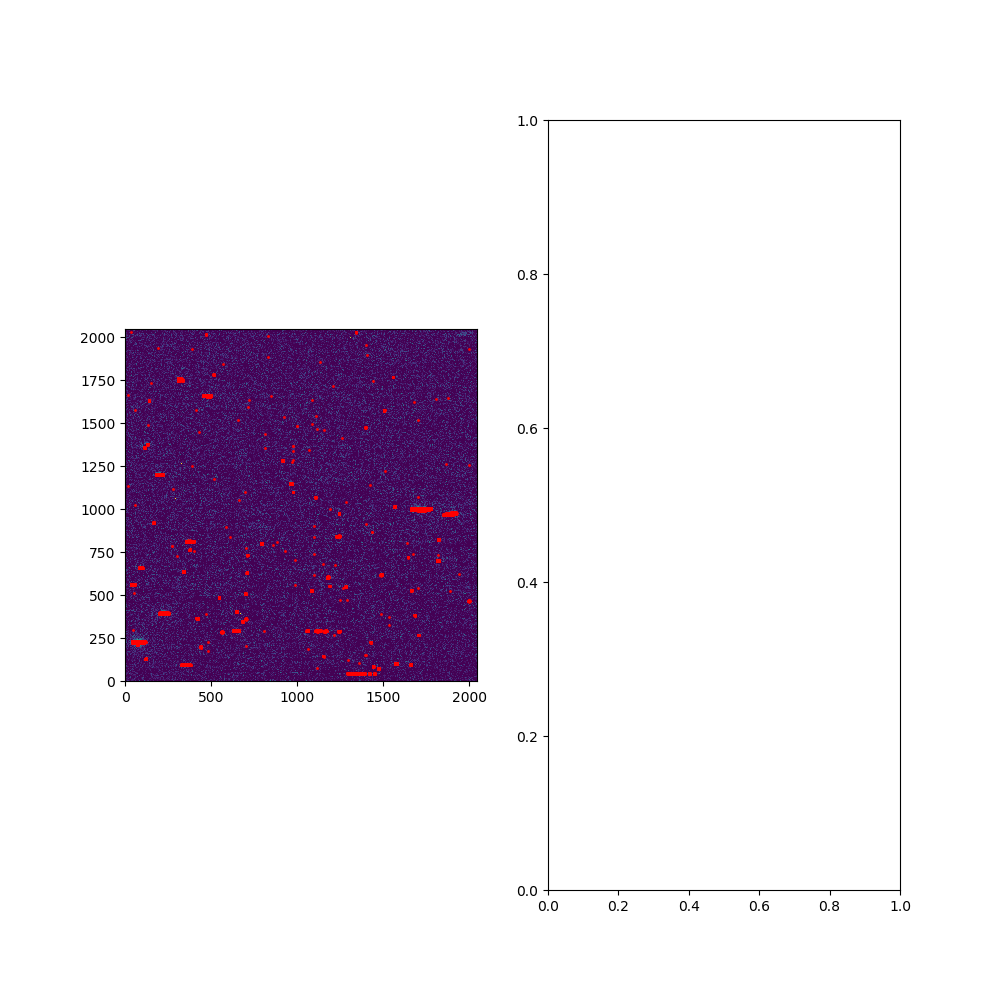

(0, 2048)

In [28]:
import sys
sys.path.insert(0, '/home/heliu/work/dev/HEXOMAP/')
import IntBin
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,10)

# images
startIdx = 180904
NRot = 720
NDet = 1
NLayer = 1
end = '.tif'
binInitial = 'dummy_2_rt_before_heat_nf_test_'
fName = f'{initial}{startIdx:06d}{end}'
img = plt.imread(fName)
bkg = np.load('test_output_bkg_z0_det_0.npy')
imgDisp = img-bkg
imgDisp[imgDisp<0] = 0
##################### ice nine result #########################33
idxRot = 0  # index of rotation (0~719)
idxL = 0    # index of detector distance(0~2)
layer=0
b=IntBin.ReadI9BinaryFiles(f'{binInitial}z{layer}_{int(idxRot)}.bin{idxL}')
print(b[0],b[1])
fig,ax = plt.subplots(1,2)

ax[0].scatter(2047-b[0],2047 - b[1],c='r',s=1,alpha=1.0)
ax[0].imshow(imgDisp[::-1],vmin=0,vmax=20)
ax[0].axis('scaled')
ax[0].set_xlim((0,2048))
ax[0].set_ylim((0,2048))

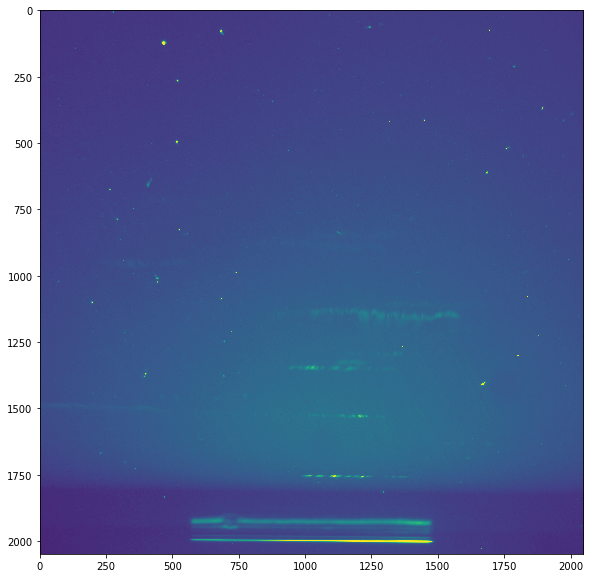

In [19]:
import numpy as np
bkg = np.load('test_output_bkg_z0_det_0.npy')
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(bkg,vmin=0,vmax=100)
plt.show()

# test for zero cross log:

In [165]:
startIdx = 180904
NRot = 720
NDet = 1
NLayer = 1
end = '.tif'
initial = '/home/heliu/work/shahani_feb19_part/nf_part/dummy_2_rt_before_heat_nf/dummy_2_rt_before_heat_nf_'
fName = f'{initial}{startIdx:06d}{end}'

img = plt.imread(fName)
bkg = np.load('test_output_bkg_z0_det_0.npy')
imgSub = img- bkg
imgSubMed = ndi.median_filter(imgSub,size=3)

# plt.imshow(img,vmin=0,vmax=50)
# plt.show()
# plt.imshow(imgSub,vmin=0,vmax=10)
# plt.show()
# plt.imshow(imgSubMed,vmin=10,vmax=20)
# plt.show()

time taken:2.0831196308135986


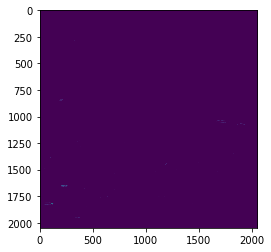

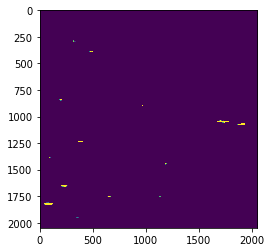

136


In [166]:
%matplotlib inline
imgBase = imgSubMed - 10
imgBase[imgBase<0] = 0
log = ndi.gaussian_laplace(imgBase,sigma=0.75)
logMedian = ndi.median_filter(log, size=3)
label,N = ndi.label(log<0)
lX = []
lY = []
lID = []
lIntensity = []
start = time.time()
for i in range(N):
    label
    vMax = np.max(imgBase[label==i].ravel())
    if vMax > 0:
        x, y = np.where((label==i)*(imgBase>vMax*0.1))
        for i,xx in enumerate(x):
            lX.append(xx)
            yy = y[i]
            lY.append(yy)
            lIntensity.append(imgBase[xx,yy])
            lID.append(label[xx,yy])
end = time.time()
print(f'time taken:{end- start}')
plt.imshow(log,vmin=0,vmax=50)
plt.show()
plt.imshow(imgBase,vmin=0,vmax=10)
plt.show()
print(N)

<IPython.core.display.Javascript object>


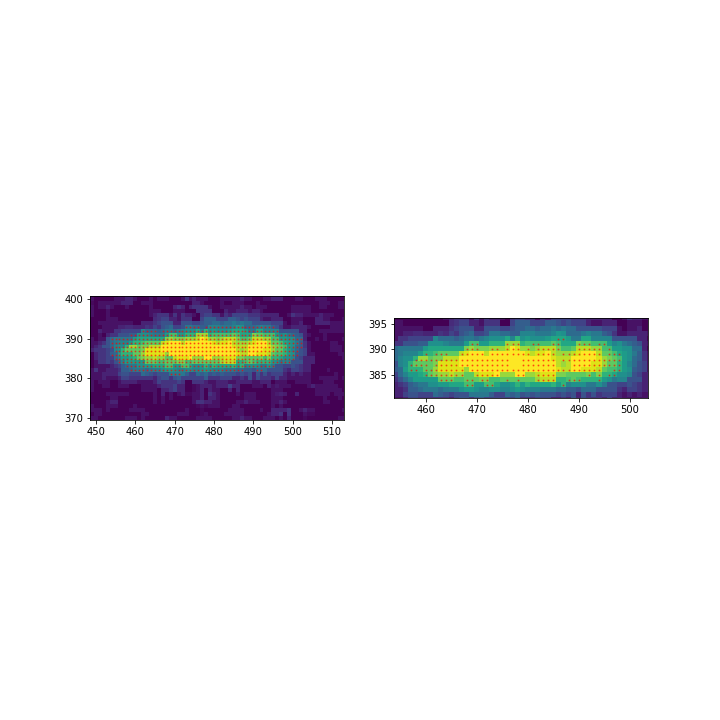

In [157]:
import sys
sys.path.insert(0, '/home/heliu/work/dev/HEXOMAP/')
import IntBin
%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,10)
idxRot = 0  # index of rotation (0~719)
idxL = 0    # index of detector distance(0~2)
b=IntBin.ReadI9BinaryFiles('/home/yufengs/shahani19/dummy_2_before_heat_reduced/dummy_2_z0_{0:06d}.bin{1}'.format(int(idxRot),idxL))

fig,ax = plt.subplots(1,2)
ax[0].imshow(imgSubMed,vmin=0,vmax=20)
ax[0].scatter(2047-b[0],b[1],c='r',s=1,alpha=0.5)
ax[0].axis('scaled')
ax[0].set_xlim((0,2048))
ax[0].set_ylim((0,2048))

ax[1].imshow(imgSubMed,vmin=0,vmax=20)
ax[1].scatter(lY,np.array(lX),c='r',s=1,alpha=0.5)
ax[1].axis('scaled')
ax[1].set_xlim([0, 2048])
ax[1].set_ylim([0, 2048])

plt.show()

<IPython.core.display.Javascript object>


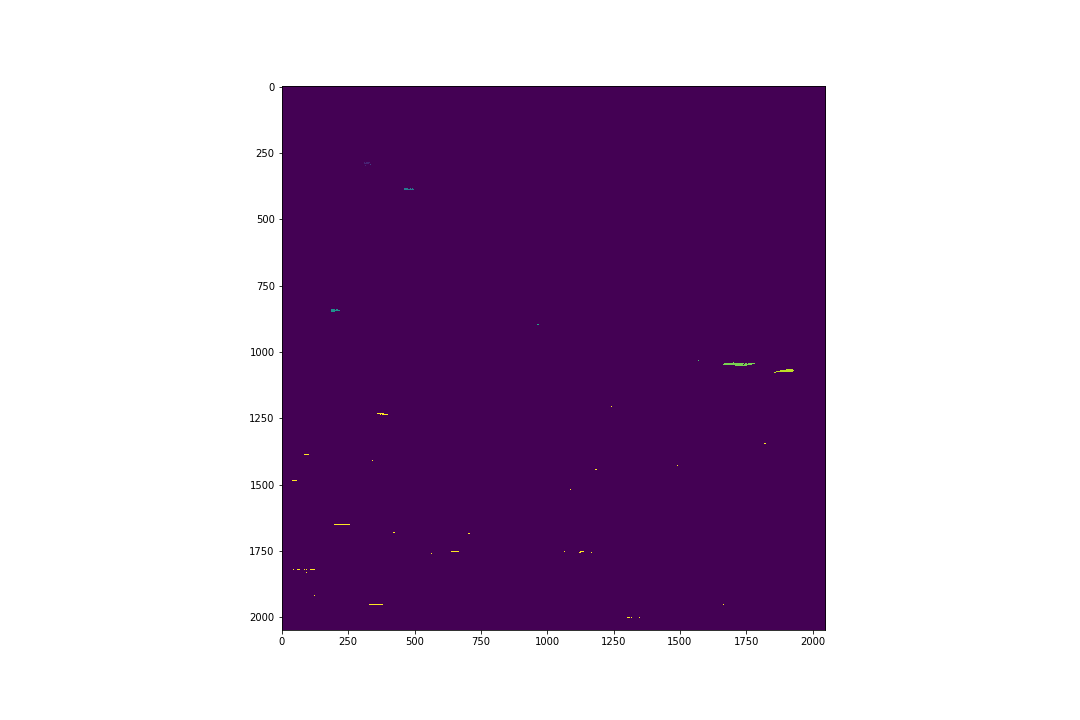

55


In [113]:
%matplotlib notebook
plt.imshow((imgBase>0)*label,vmin=0,vmax=10)
plt.show()
print(N)

<IPython.core.display.Javascript object>


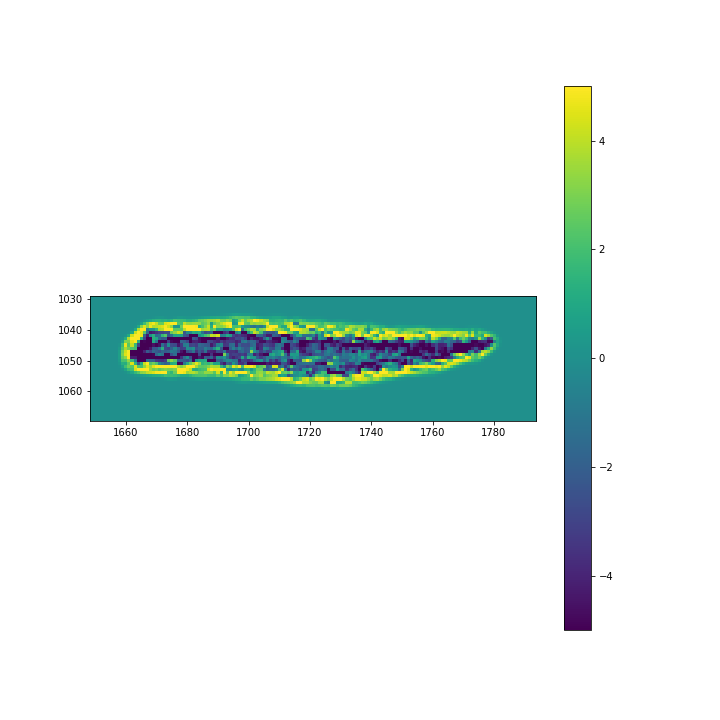

In [168]:
%matplotlib notebook
plt.imshow(log,vmin=-5,vmax=5)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


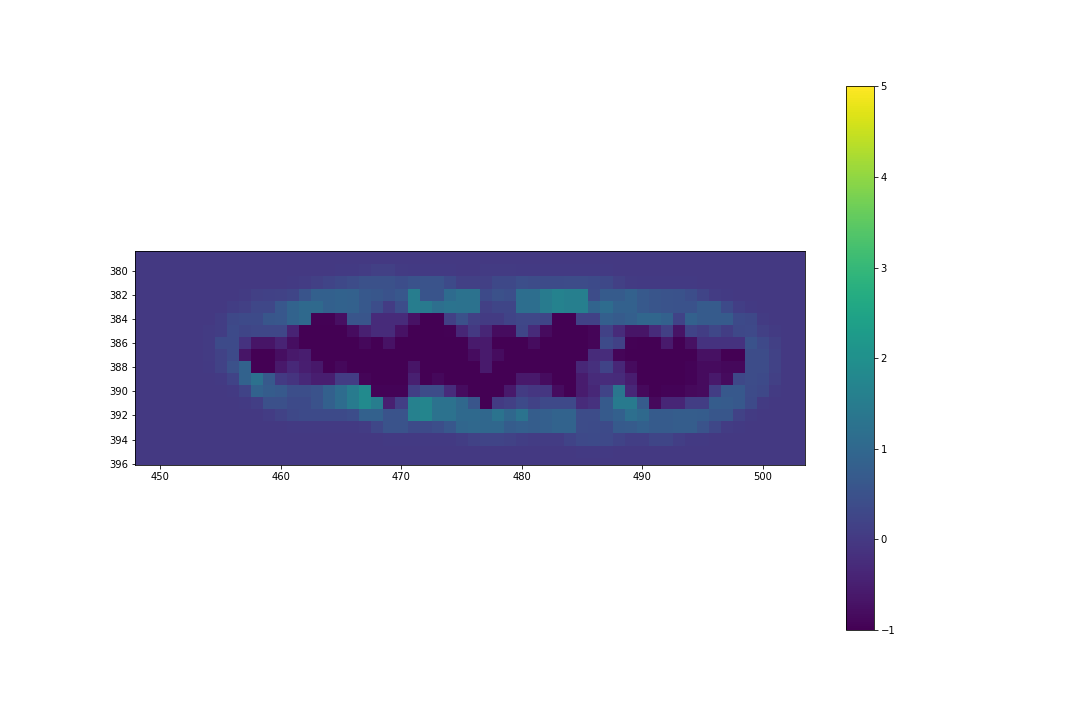

In [114]:
plt.imshow(logMedian,vmin=-1,vmax=5)
plt.colorbar()
plt.show()

125
 124time taken:1.9309310913085938
         50254 function calls in 2.551 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    2.551    1.276 /opt/anaconda/anaconda3/envs/pycuda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3228(run_code)
        2    0.000    0.000    2.551    1.276 {built-in method builtins.exec}
        1    0.009    0.009    2.551    2.551 <ipython-input-4-6775a9f1d12e>:78(<module>)
        1    0.302    0.302    2.542    2.542 <ipython-input-4-6775a9f1d12e>:6(segmentation)
      252    1.184    0.005    1.184    0.005 {built-in method numpy.core.multiarray.where}
      189    0.383    0.002    0.383    0.002 {built-in method builtins.max}
        2    0.000    0.000    0.301    0.151 /opt/anaconda/anaconda3/envs/pycuda3/lib/python3.7/site-packages/scipy/ndimage/filters.py:1189(median_filter)
        2    0.000    0.000    0.301    0.151 /opt/anaconda/anaco

<IPython.core.display.Javascript object>


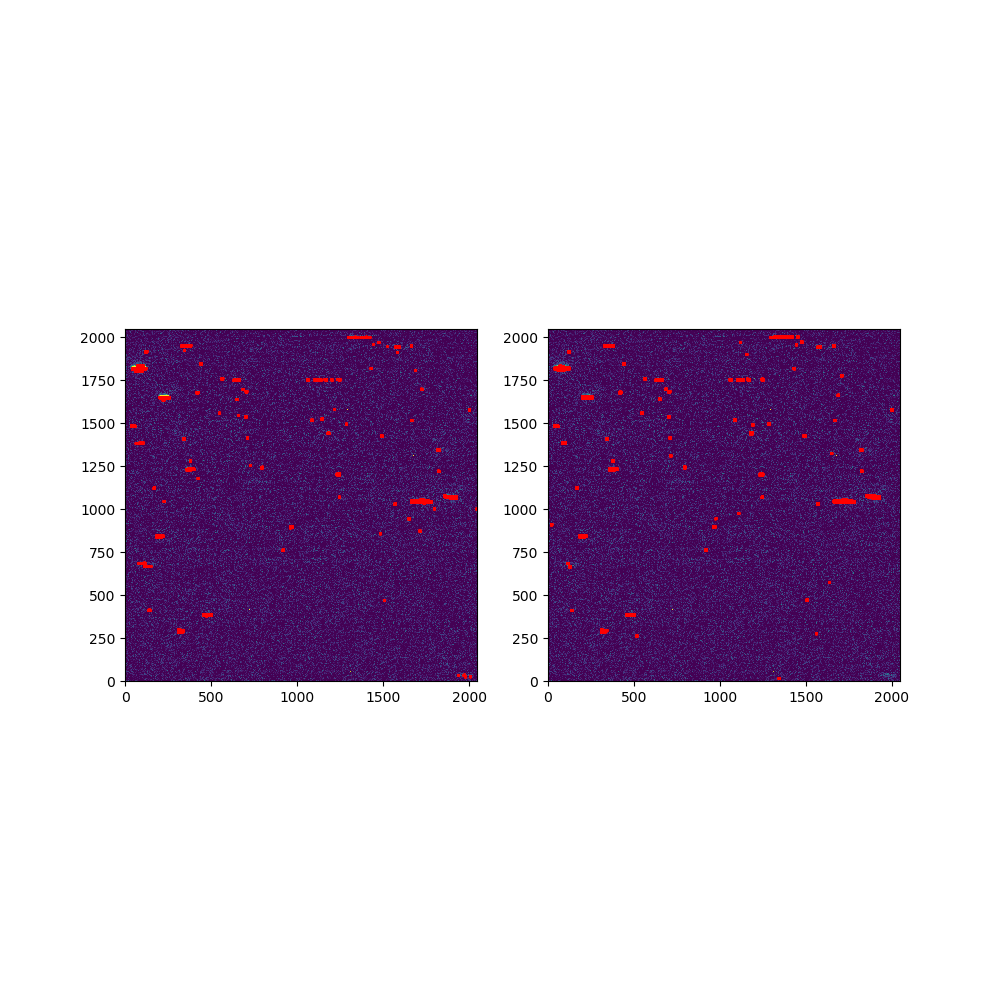

In [4]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import time
%matplotlib notebook
def segmentation(img, bkg, baseline=10, minNPixel=4):
    '''
    baseline: signal fluctuation, may need to change according to exposure time?
    minNPixel: number of pixel limit
    '''
    imgSub = img- bkg
    imgSubMed = ndi.median_filter(imgSub,size=2)
    imgBase = imgSub - baseline
    imgBase[imgBase<0] = 0
    imgBaseMedian = ndi.median_filter(imgBase,size=2)
    log = ndi.gaussian_laplace(imgBaseMedian,sigma=1.5)
    #logMedian = ndi.median_filter(log, size=3)
    label,N = ndi.label(log<0)
    label = ndi.grey_dilation(label,size=(3,3))
    lX = []
    lY = []
    lID = []
    lIntensity = []
    start = time.time()
# fill hole??? probably not a good idea in some cases.
    print(N)
    for i in range(N):
        sys.stdout.write(f'\r {i}')
        sys.stdout.flush()
        mask = (label==i)
        #mask = ndi.binary_dilation(mask,iterations=2)
        # fill hole??? probably not a good idea in some cases.
        #mask = ndi.binary_fill_holes(mask)
        #vMax = np.max(imgSubMed[mask].ravel())
        x, y = np.where(mask)
        v = imgSubMed[x, y]
        vMax = max(v)
        if vMax > baseline:
            #x, y = np.where(mask*(imgSubMed>vMax*0.1))
            aIdx = np.where(v>(vMax*0.1))[0]
            #print(aIdx)
            if aIdx.size>minNPixel:
                for idx in aIdx:
                    lX.append(x[idx])
                    lY.append(y[idx])
                    lIntensity.append(v[idx])
                    lID.append(i)
    end = time.time()
    print(f'time taken:{end- start}')
    return lX, lY, lID, lIntensity


import sys
sys.path.insert(0, '/home/heliu/work/dev/HEXOMAP/')
import IntBin
%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,10)

# images

pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())


##################### ice nine result #########################33
idxRot = 0  # index of rotation (0~719)
idxL = 0    # index of detector distance(0~2)
b=IntBin.ReadI9BinaryFiles('/home/yufengs/shahani19/dummy_2_before_heat_reduced/dummy_2_z0_{0:06d}.bin{1}'.format(int(idxRot),idxL))
fig,ax = plt.subplots(1,2)
ax[0].imshow(imgDisp,vmin=0,vmax=20)
ax[0].scatter(2047-b[0],b[1],c='r',s=1,alpha=1.0)
ax[0].axis('scaled')
ax[0].set_xlim((0,2048))
ax[0].set_ylim((0,2048))

################### python result #################################
ax[1].imshow(imgDisp,vmin=0,vmax=20)
ax[1].scatter(lY,np.array(lX),c='r',s=1,alpha=1.0)
ax[1].axis('scaled')
ax[1].set_xlim([0, 2048])
ax[1].set_ylim([0, 2048])
plt.show()

time taken:1.698519229888916


<IPython.core.display.Javascript object>


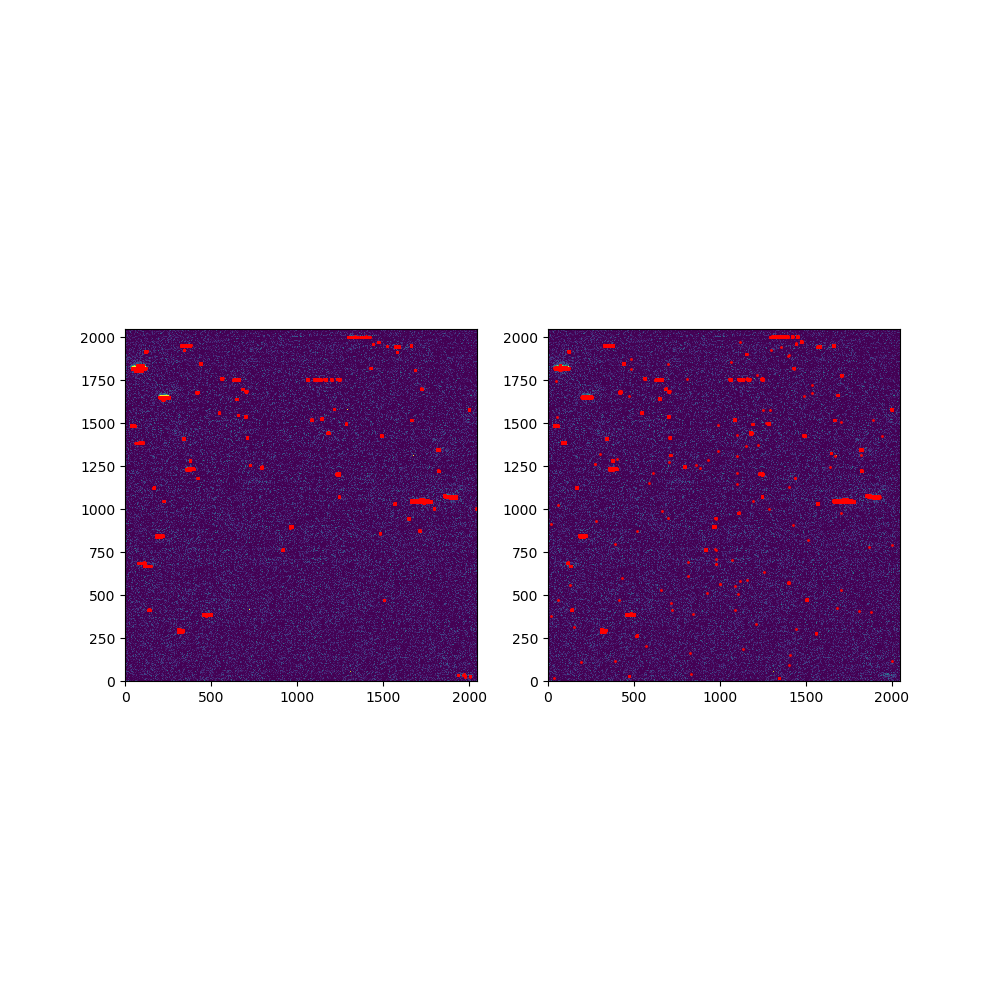

In [3]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import time
%matplotlib notebook
def segmentation(img, bkg, minNPixel=4):
    '''
    
    '''
    imgSub = img- bkg
    imgSubMed = ndi.median_filter(imgSub,size=2)
    imgBase = imgSubMed - 10
    imgBase[imgBase<0] = 0
    imgBaseMedian = ndi.median_filter(imgBase, size=2)
    log = ndi.gaussian_laplace(imgBaseMedian,sigma=1.5)
    label,N = ndi.label(log<0)
    label = ndi.grey_dilation(label,size=(3,3))
    lX = []
    lY = []
    lID = []
    lIntensity = []
    start = time.time()
# fill hole??? probably not a good idea in some cases.
    for i in range(N):
        mask = (label==i)
        # fill hole??? probably not a good idea in some cases.
        #mask = ndi.binary_fill_holes(mask)
        #mask = ndi.binary_dilation(mask,iterations=2)
        vMax = np.max(imgSubMed[mask].ravel())
        if vMax > 10:
            x, y = np.where(mask*(imgSub>max(vMax*0.1,1)))
            if x.size>minNPixel:
                for i,xx in enumerate(x):
                    lX.append(xx)
                    yy = y[i]
                    lY.append(yy)
                    lIntensity.append(imgSub[xx,yy])
                    lID.append(label[xx,yy])
    end = time.time()
    print(f'time taken:{end- start}')
    return lX, lY, lID, lIntensity



import sys
sys.path.insert(0, '/home/heliu/work/dev/HEXOMAP/')
import IntBin
%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,10)

# images
startIdx = 180904
NRot = 720
NDet = 1
NLayer = 1
end = '.tif'
initial = '/home/heliu/work/shahani_feb19_part/nf_part/dummy_2_rt_before_heat_nf/dummy_2_rt_before_heat_nf_'
fName = f'{initial}{startIdx:06d}{end}'
img = plt.imread(fName)
bkg = np.load('test_output_bkg_z0_det_0.npy')
imgDisp = img-bkg
imgDisp[imgDisp<0] = 0

lX, lY, lIntensity, lID = segmentation(img, bkg)

##################### ice nine result #########################33
idxRot = 0  # index of rotation (0~719)
idxL = 0    # index of detector distance(0~2)
b=IntBin.ReadI9BinaryFiles('/home/yufengs/shahani19/dummy_2_before_heat_reduced/dummy_2_z0_{0:06d}.bin{1}'.format(int(idxRot),idxL))
fig,ax = plt.subplots(1,2)
ax[0].imshow(imgDisp,vmin=0,vmax=20)
ax[0].scatter(2047-b[0],b[1],c='r',s=1,alpha=1.0)
ax[0].axis('scaled')
ax[0].set_xlim((0,2048))
ax[0].set_ylim((0,2048))

################### python result #################################
ax[1].imshow(imgDisp,vmin=0,vmax=20)
ax[1].scatter(lY,np.array(lX),c='r',s=1,alpha=1.0)
ax[1].axis('scaled')
ax[1].set_xlim([0, 2048])
ax[1].set_ylim([0, 2048])
plt.show()

# john's psudo code:

1. subtract background

1. subtract baseline

1. median filter

1. label

1. get minimum and maximum of each label

1. for each peak i:

    - mTimes=median*mask_of_label_i

    - log_filter_2(mTimes, sigma=1)
    
    - f2i = (float)(zfilt(mTimes))  ( zerocrossing, one pixel thick lines, then float to int)
    
        --var_array[0] = 0.5;//sigma_x of gaussian 
        
        --var_array[1] = 1.0;//sigma_y of gaussian
    
    - BinMaskCreator = (median>=0)
    
    - ImDilateBinMask = dilate(BinMaskCreator,radius=0.65)
    
    - zTimes( f2i, ImDilateBinMask) ( multiply)
    
    - ImDilate_zTimes(zTimes, radius=1)
    
    - BarrierMask = (log_filt_2<=0)
    
    - LBarrier = dilate(BarrierMask, 1)
    
    - PoolMask = (log_filt_1 <= -1)
    
    - LPool = dilate(PoolMask, 1)
    
    - mPoolxBarrier = LPoor * LBarrier
    
    - LPool = dilate(mPoolxBarrier, 1)
    
        - floodfill(LPool)
    
    - PeakMask = flood_fill(L_pool,)
